THIS IS NEW **CODE**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px
import openai  # For advanced LLM integration (optional)
import logging
from datetime import datetime  # For time-series analysis

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [ ]:
# Step 1: Load Dataset
try:
    df = pd.read_csv('/content/flipkart_product.csv',encoding='latin-1')  # Ensure your dataset has 'Review', 'Brand', and 'Timestamp' columns
    logging.info("Dataset loaded successfully!")
except FileNotFoundError:
    logging.error("Error: Dataset file not found. Please check the file path.")
    exit()


In [ ]:

# 🔄 Standardize Column Names Immediately After Loading
df.columns = df.columns.str.strip().str.lower()

In [ ]:

# ✅ Verify Column Names
print("Available Columns in DataFrame:", df.columns.tolist())

Available Columns in DataFrame: ['productname', 'price', 'rate', 'review', 'summary']


In [ ]:
# Step 2: Data Preprocessing
def preprocess_text(text):
    # Convert to string to handle non-string values
    text = str(text) # Convert to string explicitly
    # Remove special characters, URLs, and mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return text.strip().lower()

# Access the column using its lowercase name 'review'
df['Cleaned_Review'] = df['review'].apply(preprocess_text)

In [ ]:
# Step 3: Fine-Tune a Sentiment Analysis Model (Optional)
# Load a pre-trained model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Fine-tune the model on your dataset (example)
# Note: You need labeled data for fine-tuning
def fine_tune_model(train_texts, train_labels):
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(train_labels)
    )
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        logging_dir='./logs',
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    trainer.train()
    return model

In [ ]:
# Initialize the sentiment analyzer
sentiment_analyzer = pipeline("sentiment-analysis")  # Or load your fine-tuned model

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Add this line at the beginning of the code where the KeyError occurred
if 'Cleaned_Review' not in df.columns:
    df['Cleaned_Review'] = df['review'].astype(str).apply(preprocess_text) # Assuming preprocess_text is defined

# Existing code
# Analyze sentiment
def analyze_sentiment(text):
    result = sentiment_analyzer(text)[0]
    return result['label'], result['score']

df[['Sentiment', 'Confidence']] = df['Cleaned_Review'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# ✅ Step 3: Create 'brand' Column from 'productname'
df['brand'] = df['productname'].apply(lambda x: x.split()[0] if isinstance(x, str) else 'Unknown')

# 🔍 Verify if 'brand' column was created successfully
print("Unique Brands Extracted:", df['brand'].unique())


Unique Brands Extracted: ['Candes' 'MAHARAJA' 'Crompton' 'colcum' 'FLIPZON' 'S' 'Furnifry' 'Zofiy'
 'POOWEREST' 'Simple' 'Bhimada' 'Cosito' 'Yogini' 'METRO' 'Goodrik'
 'aniket' 'Growing' 'CLOTHOLOGY' 'Decorum' 'CLOTHSIDE' 'RIAN' 'SIE' 'LA'
 'IWS' 'MAGICAL' 'SPANGLE' 'Canon' 'Hindware' 'Faber' 'Whirlpool'
 'Eurodomo' 'Glen' 'RBGIIT' 'Flipkart' 'UPC' 'Tomex' 'DaduGirase'
 'Spotzero' 'Scotch-Brite' 'Tankit' 'Omi' 'Qozent' 'Sheen' 'SAISWAR' 'AOQ'
 'DeoDap' 'Allwin' 'liger' 'Trend' 'F8WARES' 'RIYUZONE' 'CREZON' 'Diem'
 'TITIRANGI' 'GADGETWEAR' 'SQUICKLE' 'DDARSH' 'Donizard' 'Green' 'Flying'
 'CEAT' 'HF' 'SportSoul' 'MRF' 'VICTORY' 'ArrowMax' 'Rixen' 'the' 'LURAGS'
 'TYF' 'Ostrich' 'Home' 'Urban' 'JDX' 'Embroco' 'PF' 'Prerana' 'LEADER'
 'vesco' 'Lifelong' 'HRX' 'HERO' 'AutoKraftZ' 'MOTOROLA' 'Voltas'
 'SAMSUNG' 'IFB' 'Midea' 'BOSCH' 'LG' 'Hafele' 'Siemens' 'thos'
 'CMerchants' 'Cherry' 'BLUECHIP' 'DALUCI' 'Supreme' 'Tata' 'Value' 'D&V'
 'Airtel' '7SEVEN' 'CHARDI' 'Nextron' 'SQUARO' 'Prestige

In [ ]:
df.columns = df.columns.str.lower().str.strip()  # Convert to lowercase and remove extra spaces
print("Cleaned Columns:", df.columns.tolist())


Cleaned Columns: ['productname', 'price', 'rate', 'review', 'summary', 'cleaned_review', 'sentiment', 'confidence', 'brand']


In [ ]:
print("Missing values in 'brand':", df['brand'].isnull().sum())
print("Missing values in 'sentiment':", df['sentiment'].isnull().sum())


Missing values in 'brand': 0
Missing values in 'sentiment': 0


In [ ]:
print("Available Columns in DataFrame:", df.columns.tolist())


Available Columns in DataFrame: ['productname', 'price', 'rate', 'review', 'summary', 'cleaned_review', 'sentiment', 'confidence', 'brand']


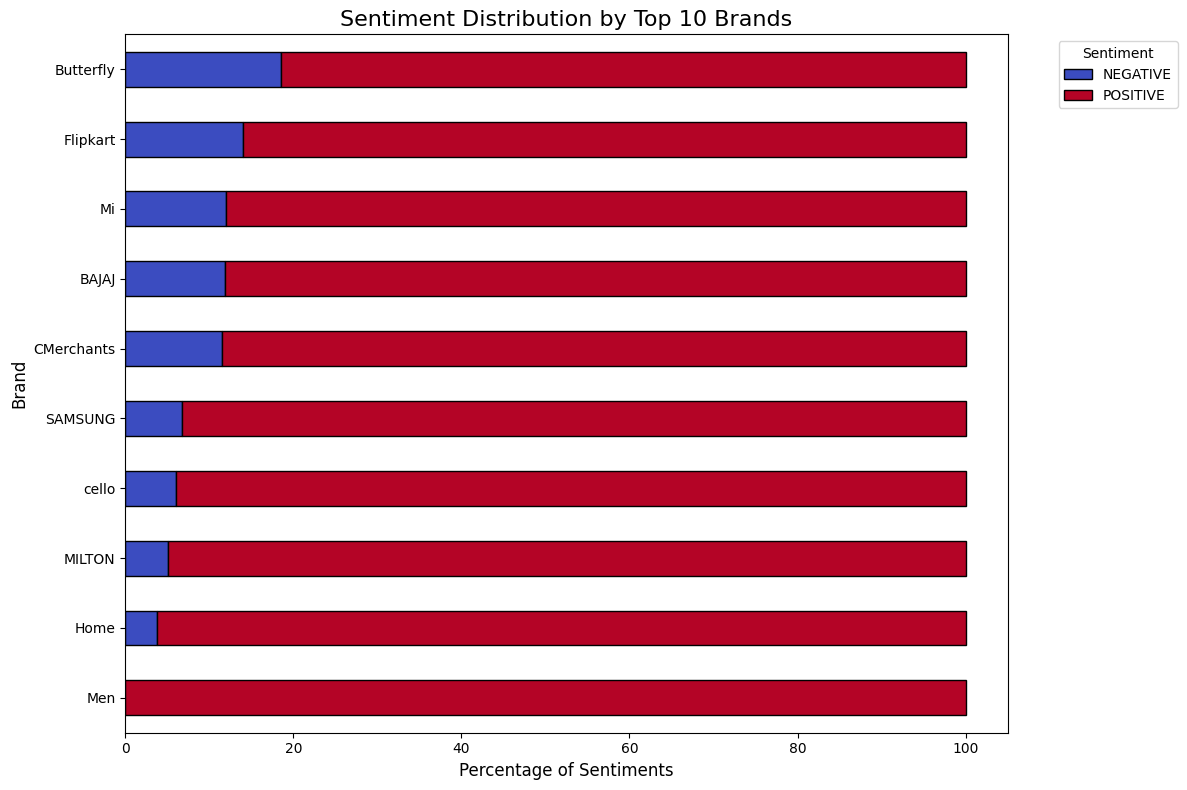

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Check if 'brand' and 'sentiment' columns exist
if 'brand' in df.columns and 'sentiment' in df.columns:
    # Get Top 10 Brands by Review Count
    top_brands = df['brand'].value_counts().nlargest(10).index
    df_top = df[df['brand'].isin(top_brands)]

    # Count sentiments for each brand
    sentiment_counts = df_top.groupby(['brand', 'sentiment']).size().reset_index(name='count')

    # Pivot for plotting
    sentiment_pivot = sentiment_counts.pivot(index='brand', columns='sentiment', values='count').fillna(0)
    sentiment_pivot_percent = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100

    # ✅ Plot: Horizontal Stacked Bar Chart (Only one plot now)
    sentiment_pivot_percent.sort_values(by='POSITIVE', ascending=False).plot(
        kind='barh',
        stacked=True,
        figsize=(12, 8),
        colormap='coolwarm',
        edgecolor='black'
    )

    plt.title('Sentiment Distribution by Top 10 Brands', fontsize=16)
    plt.xlabel('Percentage of Sentiments', fontsize=12)
    plt.ylabel('Brand', fontsize=12)
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("❌ 'brand' or 'sentiment' column not found in the dataset.")


<ipython-input-16-f5505972d899>:29: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


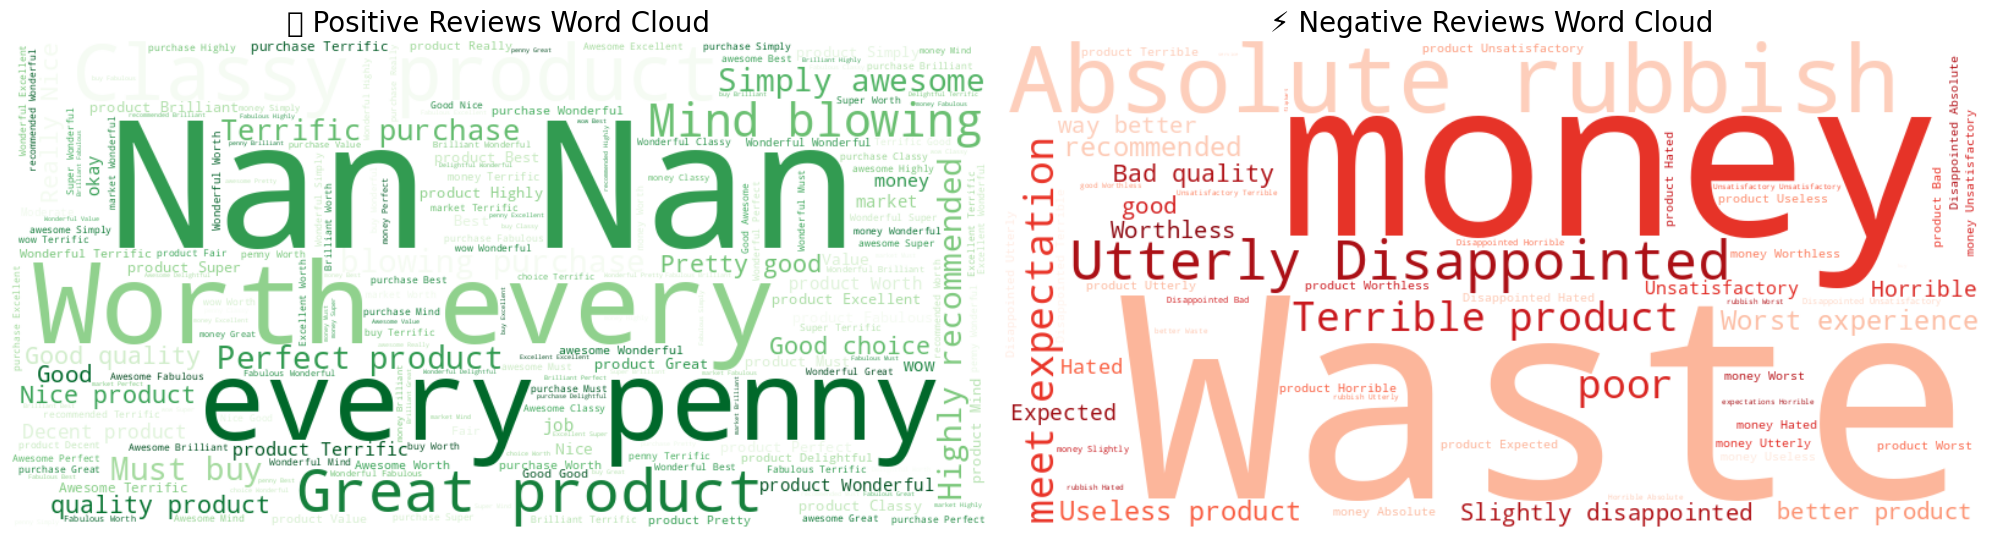

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# ✅ Combine stopwords with WordCloud defaults
stopwords = set(STOPWORDS)

# ✅ Separate Positive and Negative Reviews
# Use 'Sentiment' (capital S) to access the correct column
positive_reviews = df[df['sentiment'] == 'POSITIVE']['review'].dropna().str.cat(sep=' ')
negative_reviews = df[df['sentiment'] == 'NEGATIVE']['review'].dropna().str.cat(sep=' ')

# ✅ Generate Word Clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='Greens').generate(positive_reviews)
negative_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='Reds').generate(negative_reviews)

# ✅ Plot Word Clouds
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Positive Word Cloud
axs[0].imshow(positive_wc, interpolation='bilinear')
axs[0].set_title('🌟 Positive Reviews Word Cloud', fontsize=20)
axs[0].axis('off')

# Negative Word Cloud
axs[1].imshow(negative_wc, interpolation='bilinear')
axs[1].set_title('⚡ Negative Reviews Word Cloud', fontsize=20)
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Step 5: Topic Modeling (LDA)
# Ensure 'Cleaned_Review' column exists
if 'Cleaned_Review' not in df.columns:
    # Assuming preprocess_text function is already defined
    # Convert column name to lowercase for access
    df['Cleaned_Review'] = df['review'].astype(str).apply(preprocess_text)

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Cleaned_Review'])

In [ ]:
# Apply Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), no_top_words=10)

Topic 1:
money buy worth waste disappointed absolute rubbish poor utterly worst
Topic 2:
product recommended great classy perfect highly terrific purchase quality nice
Topic 3:
wonderful just wow terrific super excellent delightful valueformoney does job
Topic 4:
good best worth penny market fabulous choice pretty hated price
Topic 5:
nan awesome nice brilliant purchase mindblowing simply really worthless expectations
